<a href="https://colab.research.google.com/github/racego/AIRE_LHV_2025_OLIMPIADAS_STEM/blob/main/ICA_LHV_INFORME_28_10_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0) Instalar dependencias

In [1]:
!pip install --quiet openpyxl pandas numpy matplotlib seaborn scikit-learn ipywidgets gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.0 MB/s eta 0:00:00


# 1) Importar librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from ipywidgets import interact, FloatSlider, fixed, HBox, VBox, Label, HTML
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# A. CARGA DE **DATOS**

In [3]:
sheet_id = "17tyystAU0RYbr0XjElsvS90lOGBnlF1oQneJmGAtTOM"
url_xlsx = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx"

print("Leyendo Google Sheet (export xlsx). Si falla, revisa permisos de compartición...")
df_raw = pd.read_excel(url_xlsx, sheet_name="CONSOLIDADO", engine='openpyxl')
print("Datos cargados. Filas:", len(df_raw))
display(df_raw.head(3))

Leyendo Google Sheet (export xlsx). Si falla, revisa permisos de compartición...
Datos cargados. Filas: 1467


,CODIGO,ESTACIONID,RIOID,CAMPANAID,FECHA,TIPO,OBSERVACIONES,HORA_INICIAL,HORA_FINAL,Base,...,Sólidos Suspendidos Totales [SST],Grasas y Aceites,SAAM,Coliformes Totales,Fósforo Total [P],Nitrógeno Total Kjeldahl [NTK],Coliformes Fecales,Nitratos,Nitritos,Nitrógeno Total
0,113257,QLI-Villa del Diamante,NaN,NaN,2015-08-24,1,"COORDENADAS GEOGRAFICAS N04°33'16,7'' W74°09'...",10:30:00,12:30:00,1.6,...,88.0,3.98,0.150,12033000.0,0.485,20.40,130000.0,0.507,0.056,20.963
1,113258,QLI-El Satélite,NaN,NaN,2015-08-24,1,"COORDENADAS GEOGRAFICAS N04°34'10,4, W74°08'5...",07:00:00,09:00:00,4,...,188.0,5.19,0.166,1413600.0,3.990,19.90,35000.0,0.793,0.056,20.749
2,113260,QLI-Bella Flor,NaN,NaN,2015-08-24,1,"COORDENADAS GEOGRAFICAS N04°32'43,4'', W74°09...",12:00:00,14:00:00,6,...,60.0,1.61,0.150,21720000.0,2.850,6.89,2508000.0,2.000,0.107,8.997


# B. EXPLORACIÓN RÁPIDA

In [4]:
print("\nColumnas disponibles (muestra):")
print(list(df_raw.columns)[:60])


Columnas disponibles (muestra):
['CODIGO', 'ESTACIONID', 'RIOID', 'CAMPANAID', 'FECHA', 'TIPO', 'OBSERVACIONES', 'HORA_INICIAL', 'HORA_FINAL', 'Base', 'Altura', 'Caudal_1', 'Caudal_2', 'Caudal_3', 'Caudal_4', 'Caudal_5', 'Caudal_Prom', 'pH_1', 'pH_2', 'pH_3', 'pH_4', 'pH_5', 'pH_Prom', 'Temp_1', 'Temp_2', 'Temp_3', 'Temp_4', 'Temp_5', 'Temp_Prom', 'Cond_1', 'Cond_2', 'Cond_3', 'Cond_4', 'Cond_5', 'Cond_Prom', 'OD_1', 'OD_2', 'OD_3', 'OD_4', 'OD_5', 'OD_Prom', 'DBO5 Total', 'DQO Total', 'Sólidos Suspendidos Totales [SST]', 'Grasas y Aceites', 'SAAM', 'Coliformes Totales', 'Fósforo Total [P]', 'Nitrógeno Total Kjeldahl [NTK]', 'Coliformes Fecales', 'Nitratos', 'Nitritos', 'Nitrógeno Total']


# C. MAPEO ROBUSTO DE COLUMNAS (maneja variaciones)
# Nombres que buscamos (variantes habituales)

In [6]:
candidates = {
    "OD": ["OD_Prom", "Oxígeno Disuelto [OD Winkler]", "Oxígeno Disuelto", "OD_Prom (mg/L)", "OD Prom", "OD"],
    "pH": ["pH_Prom", "pH_Prom", "pH", "pH Prom", "pH_Prom (unidad)"],
    "DBO5": ["DBO5 Total", "DBO5", "DBO5_Total", "DBO5 Total (mg/L)", "DBO5Total"],
    "SST": ["Sólidos Suspendidos Totales [SST]", "SST", "Sólidos Suspendidos Totales", "SST_Total"]
}

def find_column(df, name_list):
    for n in name_list:
        if n in df.columns:
            return n
    # try case-insensitive contains
    for col in df.columns:
        for n in name_list:
            if n.lower() in col.lower().replace(" ", "").replace("_",""):
                return col
    return None

col_od = find_column(df_raw, candidates["OD"])
col_ph = find_column(df_raw, candidates["pH"])
col_dbo5 = find_column(df_raw, candidates["DBO5"])
col_sst = find_column(df_raw, candidates["SST"])

print("\nColumnas detectadas:")
print("OD  ->", col_od)
print("pH  ->", col_ph)
print("DBO5->", col_dbo5)
print("SST ->", col_sst)

if None in (col_od, col_ph, col_dbo5, col_sst):
    raise RuntimeError("No se encontraron todas las columnas requeridas. Revisa nombres en la hoja CONSOLIDADO.")

# Construir df con solo las columnas requeridas (más fecha opcional si existe)
cols_to_use = [col_ph, col_od, col_dbo5, col_sst]
if 'FECHA' in df_raw.columns:
    cols_to_use = ['FECHA'] + cols_to_use

df = df_raw[cols_to_use].copy()
# normalizar nombres
df = df.rename(columns={col_ph: 'pH', col_od: 'OD', col_dbo5: 'DBO5', col_sst: 'SST'})
# convertir a numérico y eliminar nulos
df['pH'] = pd.to_numeric(df['pH'], errors='coerce')
df['OD'] = pd.to_numeric(df['OD'], errors='coerce')
df['DBO5'] = pd.to_numeric(df['DBO5'], errors='coerce')
df['SST'] = pd.to_numeric(df['SST'], errors='coerce')
df = df.dropna().reset_index(drop=True)
print("\nRegistros válidos tras limpieza:", len(df))
display(df.head(4))



Columnas detectadas:
OD  -> OD_Prom
pH  -> pH_Prom
DBO5-> DBO5 Total
SST -> Sólidos Suspendidos Totales [SST]

Registros válidos tras limpieza: 1465


,FECHA,pH,OD,DBO5,SST
0,2015-08-24,7.688,5.176,74.0,88.0
1,2015-08-24,7.636,3.866,146.0,188.0
2,2015-08-24,7.322,4.878,40.0,60.0
3,2015-08-24,8.042,6.172,80.0,143.0


# D. PROCESAMIENTO: funciones de subíndice (0..1)

In [7]:
# Basado en la metodología IDEAM y adaptaciones pedagógicas.
# Estas funciones transforman la concentración a un subíndice entre 0 y 1.
def sub_pH(ph):
    # Ideal alrededor de 7.0-8.5; mapeo simétrico simple
    if ph <= 0 or ph>14:
        return 0.0
    # triangular centered at 7.5: max 1.0 at 7.5, linear decay 0.1 per unit
    ideal = 7.5
    val = 1 - (abs(ph - ideal) / 7.5)  # scales roughly 0..1
    return float(np.clip(val, 0, 1))

def sub_OD(od):
    # OD en mg/L. Suponemos rango 0-14 (14 muy bueno)
    val = od / 14.0
    return float(np.clip(val, 0, 1))

def sub_DBO5(x):
    # DBO5 menor es mejor. asumimos 0..30 mg/L como rango típico
    if x <= 0: return 1.0
    if x >= 60: return 0.0
    # lineal decreciente 0->60 -> 1->0
    val = 1 - (x / 60.0)
    return float(np.clip(val, 0, 1))

def sub_SST(x):
    # Sólidos suspendidos. menor es mejor. rango 0..200
    if x <= 0: return 1.0
    if x >= 200: return 0.0
    val = 1 - (x / 200.0)
    return float(np.clip(val, 0, 1))

# Aplicar subíndices
df['I_pH'] = df['pH'].apply(sub_pH)
df['I_OD'] = df['OD'].apply(sub_OD)
df['I_DBO5'] = df['DBO5'].apply(sub_DBO5)
df['I_SST'] = df['SST'].apply(sub_SST)

# E. PONDERACIÓN: normalizar pesos indicados para 100% del ICA
#    Usuario dio: pH 0.08, OD 0.21, DBO5 0.15, SST 0.07  (suman 0.51)
#    Normalizamos esas proporciones para que sumen 1.0 (100% del ICA sobre estas 4 variables)

In [8]:
w_input = {'pH':0.08, 'OD':0.21, 'DBO5':0.15, 'SST':0.07}
sum_w = sum(w_input.values())
w = {k: v/sum_w for k,v in w_input.items()}
print("\nPesos normalizados utilizados (sum = 1):", w)

# Calcular ICA (0..1) como suma ponderada de subíndices
df['ICA'] = ( df['I_pH']*w['pH'] + df['I_OD']*w['OD'] + df['I_DBO5']*w['DBO5'] + df['I_SST']*w['SST'] )
# Para presentación, también lo escalamos 0..1 y 0..100 si se desea
df['ICA_0_100'] = df['ICA'] * 100.0


Pesos normalizados utilizados (sum = 1): {'pH': 0.1568627450980392, 'OD': 0.4117647058823529, 'DBO5': 0.29411764705882354, 'SST': 0.13725490196078433}


# F. CATEGORÍAS Y COLORES (según IDEAM / documento anexado)

In [9]:
def categoria_color(ica):
    # ica in 0..1
    if ica >= 0.91: return "Buena", "#2E86AB"   # azul
    if ica >= 0.71: return "Aceptable", "#2ECC71"  # verde
    if ica >= 0.51: return "Regular", "#F1C40F"   # amarillo
    if ica >= 0.26: return "Mala", "#E67E22"       # naranja
    return "Muy mala", "#E74C3C"                 # rojo

df[['Categoria','Color']] = df['ICA'].apply(lambda x: pd.Series(categoria_color(x)))
display(df[['pH','OD','DBO5','SST','I_pH','I_OD','I_DBO5','I_SST','ICA','ICA_0_100','Categoria']].head())


,pH,OD,DBO5,SST,I_pH,I_OD,I_DBO5,I_SST,ICA,ICA_0_100,Categoria
0,7.688,5.176,74.0,88.0,0.974933,0.369714,0.000000,0.560,0.382029,38.202876,Mala
1,7.636,3.866,146.0,188.0,0.981867,0.276143,0.000000,0.060,0.275959,27.595948,Mala
2,7.322,4.878,40.0,60.0,0.976267,0.348429,0.333333,0.700,0.490728,49.072810,Mala
3,8.042,6.172,80.0,143.0,0.927733,0.440857,0.000000,0.285,0.366174,36.617386,Mala
4,8.004,1.488,226.0,109.0,0.932800,0.106286,0.000000,0.455,0.252537,25.253725,Muy mala


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['pH'].plot(kind='hist', bins=20, title='pH')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['OD'].plot(kind='hist', bins=20, title='OD')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['DBO5'].plot(kind='hist', bins=20, title='DBO5')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Categoria').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='pH', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='pH', y='OD', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='OD', y='DBO5', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='DBO5', y='SST', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['pH']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Categoria')):
  _plot_series(series, series_name, i)
  fig.legend(title='Categoria', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('pH')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['OD']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Categoria')):
  _plot_series(series, series_name, i)
  fig.legend(title='Categoria', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('OD')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['DBO5']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Categoria')):
  _plot_series(series, series_name, i)
  fig.legend(title='Categoria', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('DBO5')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['SST']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Categoria')):
  _plot_series(series, series_name, i)
  fig.legend(title='Categoria', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('SST')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['pH'].plot(kind='line', figsize=(8, 4), title='pH')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['OD'].plot(kind='line', figsize=(8, 4), title='OD')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['DBO5'].plot(kind='line', figsize=(8, 4), title='DBO5')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Categoria'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Categoria', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Categoria'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='pH', y='Categoria', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Categoria'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='OD', y='Categoria', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Categoria'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='DBO5', y='Categoria', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# G. VISUALIZACIONES: Histograma ICA, series (si FECHA), heatmap

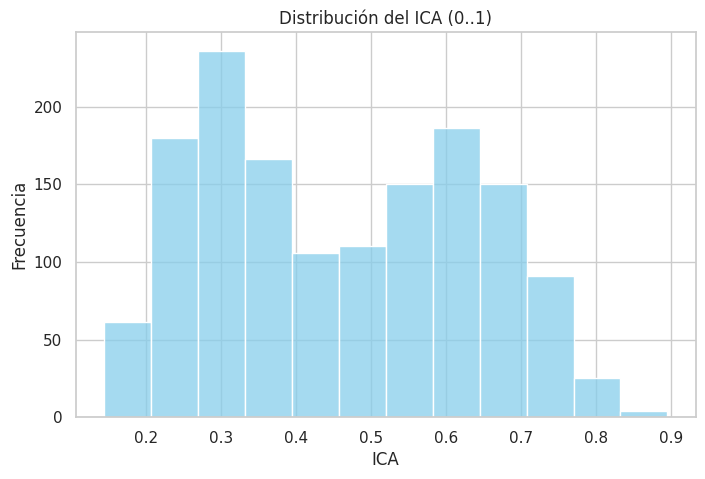

In [10]:
plt.figure(figsize=(8,5))
sns.histplot(df['ICA'], bins=12, kde=False, color='skyblue')
plt.title("Distribución del ICA (0..1)")
plt.xlabel("ICA")
plt.ylabel("Frecuencia")
plt.show()


# Si hay columna FECHA, convertir y graficar serie temporal

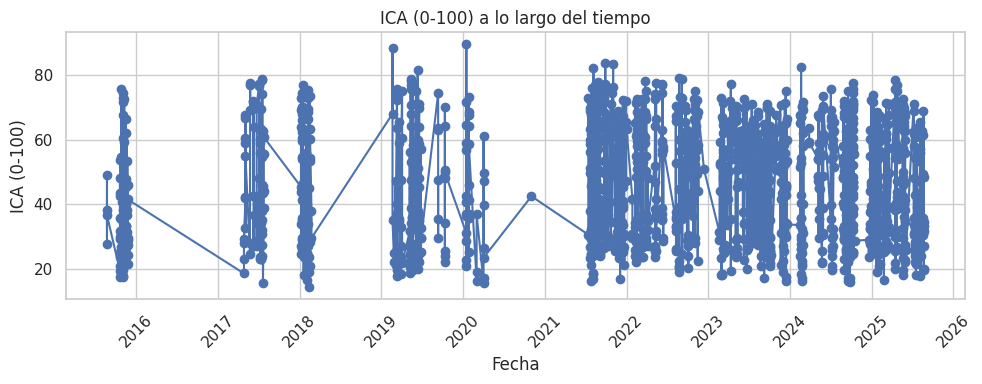

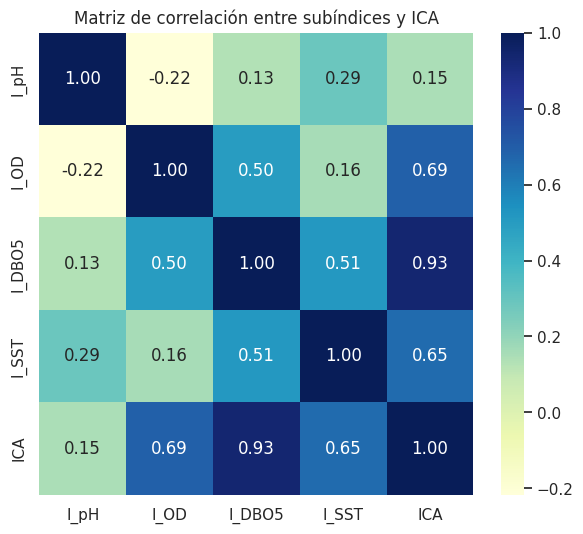

In [11]:
if 'FECHA' in df.columns:
    try:
        df['FECHA'] = pd.to_datetime(df['FECHA'])
        df_ts = df.sort_values('FECHA').reset_index(drop=True)
        plt.figure(figsize=(10,4))
        plt.plot(df_ts['FECHA'], df_ts['ICA_0_100'], marker='o')
        plt.title("ICA (0-100) a lo largo del tiempo")
        plt.ylabel("ICA (0-100)")
        plt.xlabel("Fecha")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("No se pudo graficar serie temporal:", e)

# Heatmap de correlaciones entre subíndices y variables
plt.figure(figsize=(7,6))
corr = df[['I_pH','I_OD','I_DBO5','I_SST','ICA']].corr()
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Matriz de correlación entre subíndices y ICA")
plt.show()


# H. MODELO CORRELACIONAL / PREDICTIVO (Regresión lineal)


Modelo de regresión lineal (ICA ~ pH + OD + DBO5 + SST)
R² (test): 0.722
RMSE (test): 0.0893
Intercepto: 0.7884965332614399


,Variable,Coeficiente
0,pH,-0.063315
1,OD,0.051705
2,DBO5,-0.000511
3,SST,-0.000006


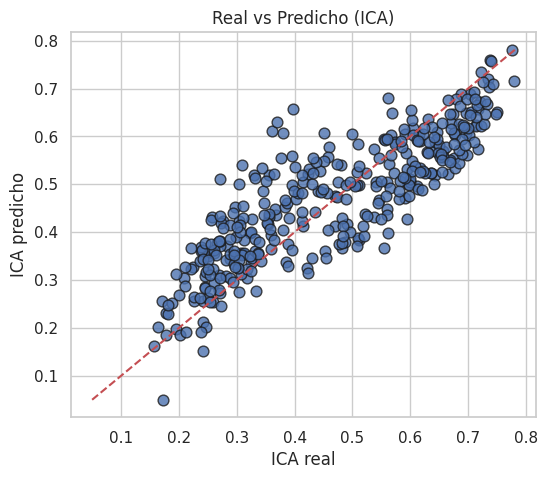

In [14]:
X = df[['pH','OD','DBO5','SST']]
y = df['ICA']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
# Calculate RMSE manually as squared=False might not be supported in older sklearn versions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nModelo de regresión lineal (ICA ~ pH + OD + DBO5 + SST)")
print(f"R² (test): {r2:.3f}")
print(f"RMSE (test): {rmse:.4f}")
print("Intercepto:", model.intercept_)
coefs = pd.DataFrame({'Variable': X.columns, 'Coeficiente': model.coef_})
display(coefs)

# Gráfica Real vs Predicho
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, s=60, edgecolor='k', alpha=0.8)
mn = min(y_test.min(), y_pred.min()); mx = max(y_test.max(), y_pred.max())
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel("ICA real")
plt.ylabel("ICA predicho")
plt.title("Real vs Predicho (ICA)")
plt.show()

# I. SIMULADOR INTERACTIVO (Sliders) - Calcula ICA y muestra color + añade punto en scatter

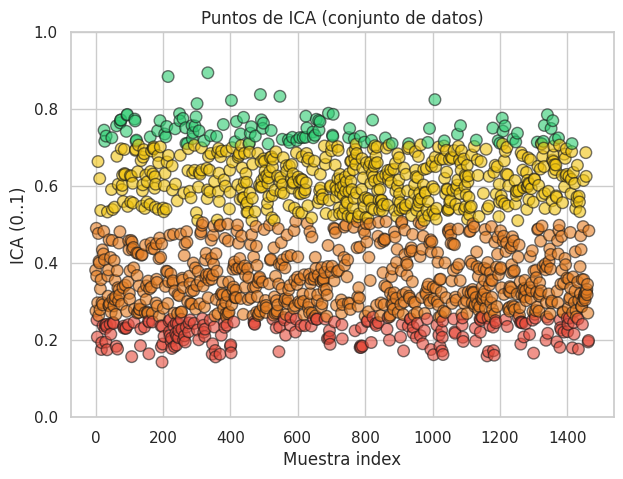

interactive(children=(FloatSlider(value=7.5, description='pH', max=9.0, min=5.0, step=0.05), FloatSlider(value…

<function __main__.simulador(pH_val=7.5, OD_val=7.0, DBO5_val=5.0, SST_val=20.0)>

In [15]:
# Preparamos la figura base con todos los ICA (para mostrar el punto del simulador)
plt.figure(figsize=(7,5))
plt.scatter(range(len(df)), df['ICA'], c=df['Color'], edgecolor='k', s=70, alpha=0.6)
plt.title("Puntos de ICA (conjunto de datos)")
plt.ylabel("ICA (0..1)")
plt.xlabel("Muestra index")
plt.ylim(0,1)
plt.show()

# Función del simulador
def simulador(pH_val=7.5, OD_val=7.0, DBO5_val=5.0, SST_val=20.0):
    # calcular subíndices
    ip = sub_pH(pH_val)
    io = sub_OD(OD_val)
    idbo = sub_DBO5(DBO5_val)
    isst = sub_SST(SST_val)
    ica = ip*w['pH'] + io*w['OD'] + idbo*w['DBO5'] + isst*w['SST']
    ica100 = ica*100
    cat, color = categoria_color(ica)
    # mostrar resultados
    display(HTML(f"<h3>Resultado simulación</h3>"))
    display(HTML(f"<b>pH</b>: {pH_val:.2f}  &nbsp;&nbsp; <b>OD (mg/L)</b>: {OD_val:.2f}  &nbsp;&nbsp; <b>DBO5</b>: {DBO5_val:.2f}  &nbsp;&nbsp; <b>SST</b>: {SST_val:.2f}"))
    display(HTML(f"<b>ICA (0..1)</b>: {ica:.3f} &nbsp;&nbsp; <b>ICA (0..100)</b>: {ica100:.1f}"))
    display(HTML(f"<div style='background:{color};padding:8px;color:white;display:inline-block;border-radius:6px'><b>{cat}</b></div>"))
    # gráfica pequeña del punto vs conjunto
    plt.figure(figsize=(6,3))
    plt.scatter(range(len(df)), df['ICA'], c=df['Color'], edgecolor='k', s=60, alpha=0.5)
    plt.scatter([len(df)+1], [ica], c=color, edgecolor='k', s=150, marker='*')
    plt.ylim(0,1)
    plt.title("ICA conjunto vs simulación (estrella=simulado)")
    plt.ylabel("ICA (0..1)")
    plt.xlabel("Muestras")
    plt.show()
    # Predicción del modelo entrenado (si se desea)
    pred_model = model.predict(np.array([[pH_val, OD_val, DBO5_val, SST_val]]))[0]
    display(HTML(f"<b>Predicción del modelo (ICA)</b>: {pred_model:.3f}"))
    # Recomendación simple
    recs = []
    if ica < 0.51:
        recs.append("Recomendación: Implementar medidas de mitigación (control de vertimientos, manejo de suelos, reducciones de carga orgánica).")
    else:
        recs.append("Recomendación: Mantener monitoreo regular y programas de conservación.")
    display(HTML("<b>Recomendaciones:</b><br>" + "<br>".join(recs)))

# Interact con sliders
interact(simulador,
         pH_val=FloatSlider(min=5.0, max=9.0, step=0.05, value=7.5, description='pH'),
         OD_val=FloatSlider(min=0.0, max=14.0, step=0.1, value=7.0, description='OD (mg/L)'),
         DBO5_val=FloatSlider(min=0.0, max=60.0, step=0.5, value=5.0, description='DBO5'),
         SST_val=FloatSlider(min=0.0, max=200.0, step=1.0, value=20.0, description='SST')
        )

# J. GUARDAR RESULTADOS

In [16]:
# Guardar csv con ICA y subíndices
out_name = f"ICA_resultados_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df.to_csv(out_name, index=False)
print("Archivo de resultados guardado:", out_name)

Archivo de resultados guardado: ICA_resultados_20251028_133048.csv


# K. CONCLUSIÓN y próximos pasos

In [17]:
print("""
CONCLUSIÓN & PRÓXIMOS PASOS (sugerencia para la presentación):

- Hemos calculado un ICA basado en 4 variables usando ponderadores normalizados.
- El modelo es reproducible: subíndices (0..1) -> ponderación -> ICA.
- El análisis exploratorio (histograma, series, correlaciones) permite detectar tendencias y relaciones.
- La regresión lineal da una primera aproximación predictiva; su R² y RMSE indican si es necesario mejorar el modelo.
- Para mejorar: incorporar variables hidrometeorológicas (precipitación, caudal histórico), usar curvas funcionales oficiales del IDEAM para subíndices, probar modelos no-lineales (GAM, RandomForest) y aumentar el tamaño muestral.

Utiliza los gráficos y el simulador en tu exposición para mostrar cómo pequeñas variaciones en pH, OD, DBO5 y SST cambian la calidad del agua y las recomendaciones de gestión.
""")


CONCLUSIÓN & PRÓXIMOS PASOS (sugerencia para la presentación):

- Hemos calculado un ICA basado en 4 variables usando ponderadores normalizados.
- El modelo es reproducible: subíndices (0..1) -> ponderación -> ICA.
- El análisis exploratorio (histograma, series, correlaciones) permite detectar tendencias y relaciones.
- La regresión lineal da una primera aproximación predictiva; su R² y RMSE indican si es necesario mejorar el modelo.
- Para mejorar: incorporar variables hidrometeorológicas (precipitación, caudal histórico), usar curvas funcionales oficiales del IDEAM para subíndices, probar modelos no-lineales (GAM, RandomForest) y aumentar el tamaño muestral.

Utiliza los gráficos y el simulador en tu exposición para mostrar cómo pequeñas variaciones en pH, OD, DBO5 y SST cambian la calidad del agua y las recomendaciones de gestión.

